# SET ENVIRONMENT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from math import sqrt, exp
import numpy as np
from scipy.stats import skew
from scipy.signal import correlate
from tqdm import tqdm
from scipy.stats import kurtosis
from scipy.stats import iqr
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import pickle
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from collections import Counter
import random
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score


In [2]:
# Check if GPU is available and log device information

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU Device Found: ", tf.config.experimental.list_physical_devices('GPU'))
else:
    print("No GPU Device Found")


Num GPUs Available:  1
GPU Device Found:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
SEED = 2

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


# DATASET PRE-PROCESSING

## Importing

In [ ]:
# Connect Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import datasets

n_sub = 10

input_data_dir = 'drive/MyDrive/ColabData Domotics/Project/MHEALTHDATASET'
filenames = [f'mHealth_subject{i+1}' for i in range(n_sub)]

df = []
for i in range(n_sub):
    df.append(pd.read_csv(f'{input_data_dir}/{filenames[i]}.log', sep='\t'))

df[4].head() # 24 columns

,-8.3532,2.5062,-2.406,-1.821,-1.1889,0.39931,-9.4774,-2.199,0.087199,-0.70544,...,-1.4596,-10.256,-2.5961,0.38431,-0.86653,-0.65517,0.58703,22.796,29.748,0
0,-7.0730,2.1373,-2.6182,-2.0345,-1.3689,1.08420,-8.8761,-1.4746,0.087199,-0.70544,...,-1.61570,-9.6925,-2.2450,0.38431,-0.86653,-0.65517,-2.5070,18.5990,24.3130,0
1,-7.6434,2.3723,-2.4497,-2.2773,-1.4443,2.24080,-9.8723,-1.0962,0.087199,-0.70544,...,-1.63350,-8.9590,-1.8959,0.38431,-0.86653,-0.65517,-6.9379,6.3932,15.3210,0
2,-8.0995,2.4517,-2.7688,-2.4155,-1.4903,1.80160,-9.8628,-1.1314,0.063080,-0.71482,...,0.29969,-7.7175,-2.7505,0.38431,-0.86653,-0.65517,-12.2450,-3.6440,4.4847,0
3,-8.3307,2.3913,-3.0164,-2.1852,-1.3940,0.44444,-9.9628,-1.2333,0.063080,-0.71482,...,0.68226,-8.1037,-3.3739,0.40784,-0.88501,-0.66164,-17.3770,3.7383,-6.5221,0
4,-8.7935,2.8082,-2.7473,-1.9383,-1.3229,1.04350,-9.7058,-1.2769,0.063080,-0.71482,...,-0.74657,-10.2440,-1.3663,0.40784,-0.88501,-0.66164,-13.5970,4.7540,-10.0670,0


In [ ]:
for i in range(n_sub):
    print(df[i].shape)

(161279, 24)
(130560, 24)
(122111, 24)
(116735, 24)
(119807, 24)
(98303, 24)
(104447, 24)
(129023, 24)
(135167, 24)
(98303, 24)


In [ ]:
df[0].head()

,-9.8184,0.009971,0.29563,0.0041863,0.0041863.1,2.1849,-9.6967,0.63077,0.1039,-0.84053,...,-8.6499,-4.5781,0.18776,-0.44902,-1.0103,0.034483,-2.35,-1.6102,-0.030899,0
0,-9.8489,0.52404,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0
1,-9.6602,0.18185,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0
2,-9.6507,0.21422,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0
3,-9.7030,0.30389,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0
4,-9.6511,0.23261,0.42094,0.154890,0.138150,2.2639,-9.4493,0.61267,0.098330,-0.84240,...,-8.7247,-4.0449,0.506090,-0.45686,-1.0082,0.025862,0.18674,0.720440,-0.364480,0


In [ ]:
# Insert column titles (also to concatenate in the correct way)

col_titles = [
    'accX_chest', 'accY_chest', 'accZ_chest',
    'EC1_chest', 'EC2_chest',

    'accX_lank', 'accY_lank', 'accZ_lank',
    'gyroX_lank', 'gyroY_lank', 'gyroZ_lank',
    'magX_lank', 'magY_lank', 'magZ_lank',

    'accX_rarm', 'accY_rarm', 'accZ_rarm',
    'gyroX_rarm', 'gyroY_rarm', 'gyroZ_rarm',
    'magX_rarm', 'magY_rarm', 'magZ_rarm',

    'label'
]

# Iterate through the list of DataFrames, set the column titles and identify the user
for i in range(n_sub):
    df[i].columns = col_titles
    df[i]['user'] = i

df[4].head()

,accX_chest,accY_chest,accZ_chest,EC1_chest,EC2_chest,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,...,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,-7.0730,2.1373,-2.6182,-2.0345,-1.3689,1.08420,-8.8761,-1.4746,0.087199,-0.70544,...,-9.6925,-2.2450,0.38431,-0.86653,-0.65517,-2.5070,18.5990,24.3130,0,4
1,-7.6434,2.3723,-2.4497,-2.2773,-1.4443,2.24080,-9.8723,-1.0962,0.087199,-0.70544,...,-8.9590,-1.8959,0.38431,-0.86653,-0.65517,-6.9379,6.3932,15.3210,0,4
2,-8.0995,2.4517,-2.7688,-2.4155,-1.4903,1.80160,-9.8628,-1.1314,0.063080,-0.71482,...,-7.7175,-2.7505,0.38431,-0.86653,-0.65517,-12.2450,-3.6440,4.4847,0,4
3,-8.3307,2.3913,-3.0164,-2.1852,-1.3940,0.44444,-9.9628,-1.2333,0.063080,-0.71482,...,-8.1037,-3.3739,0.40784,-0.88501,-0.66164,-17.3770,3.7383,-6.5221,0,4
4,-8.7935,2.8082,-2.7473,-1.9383,-1.3229,1.04350,-9.7058,-1.2769,0.063080,-0.71482,...,-10.2440,-1.3663,0.40784,-0.88501,-0.66164,-13.5970,4.7540,-10.0670,0,4


In [ ]:
for i in range(len(df)):
    print(len(df[i]))

161279
130560
122111
116735
119807
98303
104447
129023
135167
98303


In [ ]:
# Concatenate datasets in a single dataset

df = pd.concat(df, ignore_index=True)

print(df.shape)
df.head()

(1215735, 25)


,accX_chest,accY_chest,accZ_chest,EC1_chest,EC2_chest,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,...,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,-9.8489,0.52404,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,0
1,-9.6602,0.18185,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,0
2,-9.6507,0.21422,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,0
3,-9.7030,0.30389,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,0
4,-9.6511,0.23261,0.42094,0.154890,0.138150,2.2639,-9.4493,0.61267,0.098330,-0.84240,...,-4.0449,0.506090,-0.45686,-1.0082,0.025862,0.18674,0.720440,-0.364480,0,0


## Cleaning

In [ ]:
# Removing first sensor data (different features)

df = df.drop(['accX_chest', 'accY_chest', 'accZ_chest', 'EC1_chest', 'EC2_chest'], axis=1)

print(df.shape)
df.head()

(1215735, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-0.197990,-0.18151,0.582980,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,0
1,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-0.374170,0.18723,0.438510,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,0
2,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-0.017271,0.18366,0.575710,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,0
3,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-0.374390,-0.54671,0.445860,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,0
4,2.2639,-9.4493,0.61267,0.098330,-0.84240,-0.68959,-0.722340,0.37420,0.010705,-8.7247,-4.0449,0.506090,-0.45686,-1.0082,0.025862,0.18674,0.720440,-0.364480,0,0


In [ ]:
# Remove all rows with label == 0 (no activity was done)

df = df[(df['label'] != 0)].reset_index(drop=True)

print(df.shape)
df.head()

(343195, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,2.6493,-9.4517,0.37683,-0.20965,-0.88931,-0.50884,0.56366,0.54482,-0.73822,-2.8439,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,0
1,2.4157,-9.5306,0.40179,-0.20965,-0.88931,-0.50884,0.56810,0.91175,-0.88628,-2.9935,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,1,0
2,2.3865,-9.5991,0.48141,-0.20037,-0.86867,-0.50688,0.21110,0.54835,-1.01980,-2.8846,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,0
3,2.3758,-9.5997,0.42919,-0.20037,-0.86867,-0.50688,0.21565,1.28220,-1.17150,-2.9245,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,1,0
4,2.3239,-9.5406,0.40038,-0.20037,-0.86867,-0.50688,0.56810,0.91175,-0.88628,-2.8963,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,1,0


In [ ]:
# Find NaN and missing values

print(df.isna().any().any())
print(df.isnull().any().any())

False
False


## Filtering

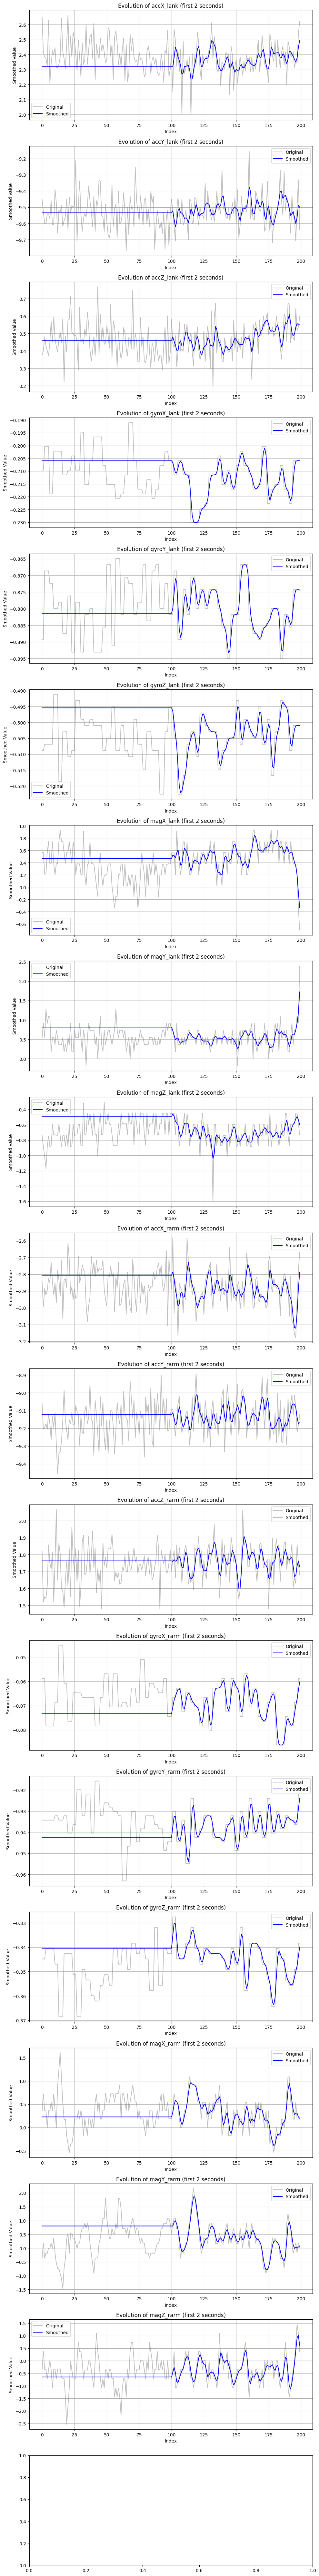

In [ ]:
# Smoothing the whole dataset

window_comp = 200 # 4 sec (50 Hz sample rate)
window_smooth = 200 # CHANGE?! BEFORE 100

df_small = df.iloc[:window_comp] # comparison of not smoothed signal

num_columns = len(df.columns)
fig, img = plt.subplots(num_columns - 1, 1, figsize=(10, 4 * num_columns))

for i, column in enumerate(df.columns[:-2]): # don't modify user and label
    df[column] = df[column].rolling(window=window_smooth, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")

    img[i].plot(df_small.index, df_small[column], label='Original', alpha=0.5, color='gray')

    img[i].plot(df_small.index, df[column].iloc[:window_comp], label='Smoothed', color='blue')
    img[i].set_xlabel('Index')
    img[i].set_ylabel('Smoothed Value')
    img[i].set_title(f'Evolution of {column} (first 2 seconds)')
    img[i].legend()
    img[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Deleting useless part due to smoothing filter

df = df.iloc[(int(window_smooth / 2)):].reset_index(drop=True)

print(df.shape)
df.head()

(343095, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,2.319285,-9.534153,0.460484,-0.205974,-0.881385,-0.495416,0.465590,0.814116,-0.487992,-2.806078,-9.122057,1.762522,-0.073336,-0.942437,-0.340438,0.227011,0.800923,-0.647414,1,0
1,2.319454,-9.521526,0.480285,-0.206759,-0.879850,-0.496550,0.522618,0.722441,-0.460701,-2.786636,-9.111562,1.759251,-0.070585,-0.937383,-0.335145,0.327447,0.801619,-0.462131,1,0
2,2.379994,-9.574404,0.454444,-0.208715,-0.875253,-0.500016,0.512365,0.599192,-0.486905,-2.825696,-9.141583,1.769835,-0.067755,-0.932572,-0.330138,0.494855,0.937033,-0.266173,1,0
3,2.449435,-9.620218,0.434301,-0.210575,-0.870993,-0.503783,0.477407,0.487943,-0.551851,-2.893485,-9.180614,1.760691,-0.066231,-0.932572,-0.330418,0.581534,0.991056,-0.466104,1,0
4,2.424567,-9.589877,0.404073,-0.210575,-0.871965,-0.507345,0.555355,0.521146,-0.577359,-2.932474,-9.171627,1.765613,-0.064713,-0.937383,-0.336223,0.560411,0.879400,-0.826890,1,0


## Normalizing

In [ ]:
# Normalizing (not standardizing because the distributions are not suitable)

minMaxScaler = MinMaxScaler()

df[['accX_lank', 'accY_lank', 'accZ_lank', 'accX_rarm', 'accY_rarm', 'accZ_rarm']] = minMaxScaler.fit_transform(df[['accX_lank', 'accY_lank', 'accZ_lank', 'accX_rarm', 'accY_rarm', 'accZ_rarm']])
df[['gyroX_lank', 'gyroY_lank', 'gyroZ_lank', 'gyroX_rarm', 'gyroY_rarm', 'gyroZ_rarm']] = minMaxScaler.fit_transform(df[['gyroX_lank', 'gyroY_lank', 'gyroZ_lank', 'gyroX_rarm', 'gyroY_rarm', 'gyroZ_rarm']])
df[['magX_lank', 'magY_lank', 'magZ_lank', 'magX_rarm', 'magY_rarm', 'magZ_rarm']] = minMaxScaler.fit_transform(df[['magX_lank', 'magY_lank', 'magZ_lank', 'magX_rarm', 'magY_rarm', 'magZ_rarm']])

print(df.shape)
df.head()

(343095, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,0.596013,0.293880,0.462586,0.450804,0.403189,0.507639,0.490327,0.523474,0.551308,0.467548,0.240274,0.467863,0.424665,0.390508,0.291440,0.531199,0.508667,0.497325,1,0
1,0.596017,0.294254,0.463051,0.450579,0.403537,0.507369,0.490413,0.523294,0.551375,0.468016,0.240532,0.467786,0.425729,0.392011,0.293447,0.531412,0.508668,0.497469,1,0
2,0.597515,0.292687,0.462444,0.450018,0.404579,0.506543,0.490397,0.523053,0.551310,0.467076,0.239794,0.468034,0.426825,0.393441,0.295346,0.531767,0.508875,0.497621,1,0
3,0.599234,0.291330,0.461971,0.449485,0.405545,0.505646,0.490344,0.522835,0.551150,0.465444,0.238834,0.467820,0.427414,0.393441,0.295240,0.531951,0.508958,0.497466,1,0
4,0.598619,0.292229,0.461261,0.449485,0.405324,0.504797,0.490462,0.522900,0.551087,0.464505,0.239055,0.467935,0.428002,0.392011,0.293038,0.531906,0.508787,0.497186,1,0


## Balancing

In [ ]:
# Look at occurrencies

n_act = 12
label_counts = []

for i in range(1, n_act + 1):
    label_counts.append((df['label'] == i).sum())
    print(f'Label {i}: ', label_counts[-1], 'repetitions')

# 10 (subjects) * 50 (Hz) * 60 (secs in a min) = 30,000 (ideal repetitions for 1 min tasks => correct for label 1 -> 5 and 9 -> 11)
# labels 1 -> 11 have comparable dimensions
# label 7 has almost 1/3 observations

Label 1:  30620 repetitions
Label 2:  30720 repetitions
Label 3:  30720 repetitions
Label 4:  30720 repetitions
Label 5:  30720 repetitions
Label 6:  28315 repetitions
Label 7:  29441 repetitions
Label 8:  29337 repetitions
Label 9:  30720 repetitions
Label 10:  30720 repetitions
Label 11:  30720 repetitions
Label 12:  10342 repetitions


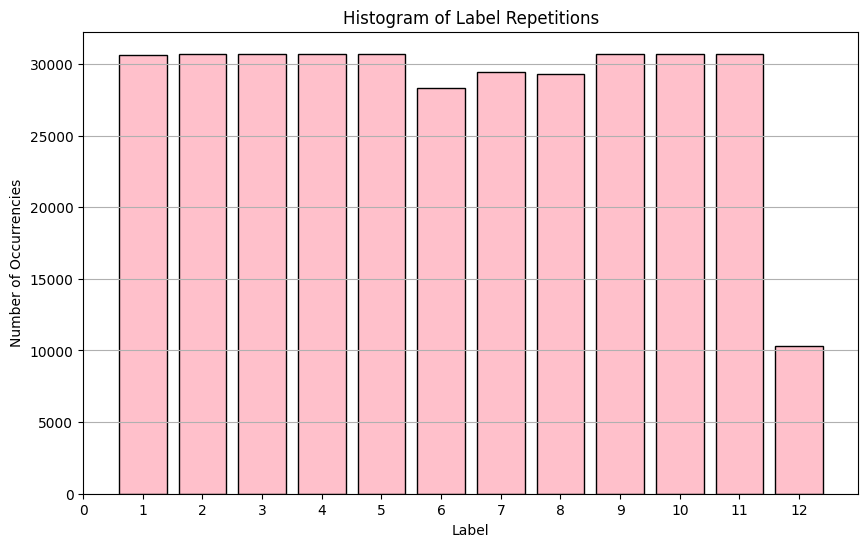

In [ ]:
# Plot the histogram

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_act + 1), label_counts, color='pink', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Number of Occurrencies')
plt.title('Histogram of Label Repetitions')
plt.xticks(range(n_act + 1))
plt.grid(axis='y')
plt.show()

In [ ]:
# Applying SMOTE on label 12

# Separate features, label and user variables
X = df.drop(['label', 'user'], axis=1)
y = df['label']
users = df['user']

# Prepare a list to store the resampled data for each user
resampled_data = []

# Iterate over each user
for user in users.unique():
    # Get data for the current user
    user_indices = (users == user)

    X_user = X[user_indices]
    y_user = y[user_indices]

    # Find average of labels occurrences excluding label 12
    label_counts = y_user.value_counts()
    average_count = int(label_counts.loc[(label_counts.index != 12)].mean())

    # Apply SMOTE to balance label 12 for the current user
    smote = SMOTE(sampling_strategy={12: average_count}, random_state=SEED)
    X_res, y_res = smote.fit_resample(X_user, y_user)

    # Combine the resampled data back into a DataFrame and add the user column
    df_resampled_user = pd.concat([X_res, y_res], axis=1)
    df_resampled_user['user'] = user

    # Append the resampled DataFrame to the list
    resampled_data.append(df_resampled_user)

# Combine all the resampled data into a single DataFrame
df = pd.concat(resampled_data, axis=0).reset_index(drop=True)

Label 1:  30620 repetitions
Label 2:  30720 repetitions
Label 3:  30720 repetitions
Label 4:  30720 repetitions
Label 5:  30720 repetitions
Label 6:  28315 repetitions
Label 7:  29441 repetitions
Label 8:  29337 repetitions
Label 9:  30720 repetitions
Label 10:  30720 repetitions
Label 11:  30720 repetitions
Label 12:  30246 repetitions


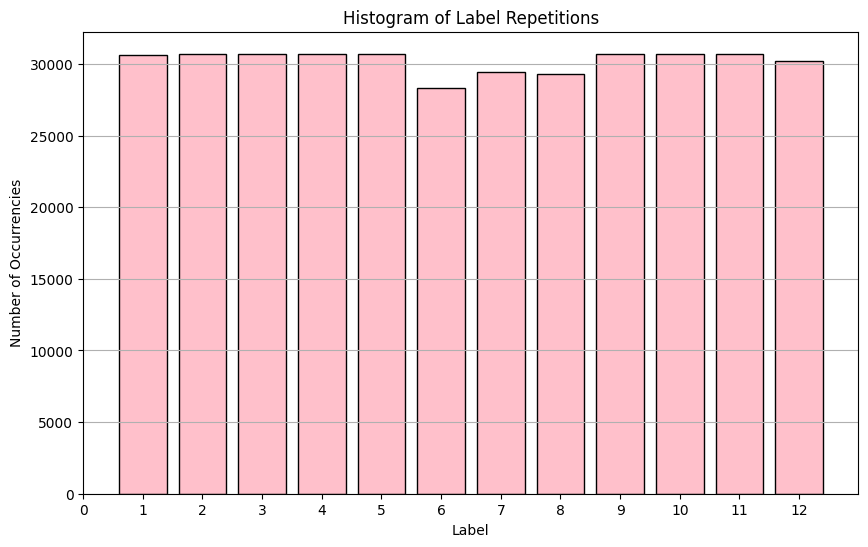

In [ ]:
# Look at final result

label_counts = []

for i in range(1, n_act + 1):
    label_counts.append((df['label'] == i).sum())
    print(f'Label {i}: ', label_counts[-1], 'repetitions')

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_act + 1), label_counts, color='pink', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Number of Occurrencies')
plt.title('Histogram of Label Repetitions')
plt.xticks(range(n_act + 1))  # Ensure x-axis labels match the labels
plt.grid(axis='y')
plt.show()

## Segmenting

In [ ]:
window_len = 2  # 2 sec
sampling_rate = 50  # 50 Hz

acc_samples1, gyr_samples1, mag_samples1 = [], [], []
acc_samples2, gyr_samples2, mag_samples2 = [], [], []
labels, user_ids = [], []

start_idx = 0

while start_idx + window_len * sampling_rate <= len(df):
    end_idx = start_idx + window_len * sampling_rate
    tmp_df = df.iloc[start_idx:end_idx]

    # Check if all data in tmp_df belongs to the same user
    user = tmp_df['user'].iloc[0]  # Assuming 'user_id' is a column in df

    if (tmp_df['user'] == user).all():
        acc_win1 = tmp_df[['accX_lank', 'accY_lank', 'accZ_lank']].to_numpy()
        gyr_win1 = tmp_df[['gyroX_lank', 'gyroY_lank', 'gyroZ_lank']].to_numpy()
        mag_win1 = tmp_df[['magX_lank', 'magY_lank', 'magZ_lank']].to_numpy()

        acc_win2 = tmp_df[['accX_rarm', 'accY_rarm', 'accZ_rarm']].to_numpy()
        gyr_win2 = tmp_df[['gyroX_rarm', 'gyroY_rarm', 'gyroZ_rarm']].to_numpy()
        mag_win2 = tmp_df[['magX_rarm', 'magY_rarm', 'magZ_rarm']].to_numpy()

        # Ensure the windows have enough measurements
        if (len(acc_win1) == window_len * sampling_rate and
            len(gyr_win1) == window_len * sampling_rate and
            len(mag_win1) == window_len * sampling_rate and
            len(acc_win2) == window_len * sampling_rate and
            len(gyr_win2) == window_len * sampling_rate and
            len(mag_win2) == window_len * sampling_rate):

            # Get the most frequent label (mode) in tmp_df
            lab = tmp_df['label'].mode()[0]

            # Store data
            acc_samples1.append(acc_win1)
            gyr_samples1.append(gyr_win1)
            mag_samples1.append(mag_win1)

            acc_samples2.append(acc_win2)
            gyr_samples2.append(gyr_win2)
            mag_samples2.append(mag_win2)

            labels.append(lab)
            user_ids.append(user)

    start_idx += window_len * sampling_rate

# Convert lists to numpy arrays
acc_samples1 = np.asarray(acc_samples1)
gyr_samples1 = np.asarray(gyr_samples1)
mag_samples1 = np.asarray(mag_samples1)

acc_samples2 = np.asarray(acc_samples2)
gyr_samples2 = np.asarray(gyr_samples2)
mag_samples2 = np.asarray(mag_samples2)

labels = np.asarray(labels)
user_ids = np.asarray(user_ids)

print(f"Accelerometer data 1:   {acc_samples1.shape}")
print(f"Gyroscope data 1:       {gyr_samples1.shape}")
print(f"Magnetometer data 1:    {mag_samples1.shape}")

print(f"Accelerometer data 2:   {acc_samples2.shape}")
print(f"Gyroscope data 2:       {gyr_samples2.shape}")
print(f"Magnetometer data 2:    {mag_samples2.shape}")

print(f"\nLabels data:            {labels.shape}")
print(f"User IDs data:          {user_ids.shape}")


Accelerometer data 1:   (3620, 100, 3)
Gyroscope data 1:       (3620, 100, 3)
Magnetometer data 1:    (3620, 100, 3)
Accelerometer data 2:   (3620, 100, 3)
Gyroscope data 2:       (3620, 100, 3)
Magnetometer data 2:    (3620, 100, 3)

Labels data:            (3620,)
User IDs data:          (3620,)


## Saving samples

In [ ]:
samples = {
    "acc_samples1": acc_samples1,
    "gyr_samples1": gyr_samples1,
    "mag_samples1": mag_samples1,

    "acc_samples2": acc_samples2,
    "gyr_samples2": gyr_samples2,
    "mag_samples2": mag_samples2,

    "user_ids": user_ids,
    "labels": labels
}

project_path = "/content/drive/MyDrive/ColabData Domotics/Project"
filename = f"{project_path}/samples.txt"

with open(filename, 'wb') as f:
    pickle.dump(samples, f)

print("Samples saved successfully!")

del samples

Samples saved successfully!


# PRE-TRAINING

## Split samples

In [ ]:
# Connect Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Take samples

project_path = "/content/drive/MyDrive/ColabData Domotics/Project"
filename = f"{project_path}/samples.txt"

with open(filename, 'rb') as f:
    dataset = pickle.load(f)

acc_samples1 = dataset["acc_samples1"]
gyro_samples1 = dataset["gyr_samples1"]
mag_samples1 = dataset["mag_samples1"]

acc_samples2 = dataset["acc_samples2"]
gyro_samples2 = dataset["gyr_samples2"]
mag_samples2 = dataset["mag_samples2"]

users = dataset["user_ids"]
labels = dataset["labels"]

# Prepare samples

samples1 = np.concatenate((acc_samples1, gyro_samples1, mag_samples1), axis=2)
samples2 = np.concatenate((acc_samples2, gyro_samples2, mag_samples2), axis=2)

print("Variables measured have dimensions:")
print(acc_samples1.shape)
print(gyro_samples1.shape)
print(mag_samples1.shape)
print()
print(acc_samples2.shape)
print(gyro_samples2.shape)
print(mag_samples2.shape)
print()
print("Final samples have dimensions:")
print(samples1.shape)
print(samples2.shape) # axis 2 has dim = 9: 3 (x, y, z) * 3 (acc, gyro, mag)
print()
print("Users and labels have dimensions:")
print(users.shape)
print(labels.shape)

Variables measured have dimensions:
(3620, 100, 3)
(3620, 100, 3)
(3620, 100, 3)

(3620, 100, 3)
(3620, 100, 3)
(3620, 100, 3)

Final samples have dimensions:
(3620, 100, 9)
(3620, 100, 9)

Users and labels have dimensions:
(3620,)
(3620,)


In [ ]:
print(labels[:5])
print(labels[-5:]) # now labels are from 1 to 12

[1 1 1 1 1]
[12 12 12 12 12]


In [ ]:
# One-Hot-Encoding for labels

enc = OneHotEncoder()
labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

print("One-Hot-Encoded labels have dimensions:")
print(labels.shape)

One-Hot-Encoded labels have dimensions:
(3620, 12)


In [ ]:
print(labels[:5])
print(labels[-5:]) # now labels are from 1 to 12 # now indices are from 0 to 11

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
# Take last user as test

# Find indices
user_9_indices = np.where(users == 9)[0]

# Extract samples and labels for user 9
samples1_test = samples1[user_9_indices]
samples2_test = samples2[user_9_indices]

labels_test = labels[user_9_indices]

print(samples1_test.shape)
print(samples2_test.shape)
print(labels_test.shape)

(355, 100, 9)
(355, 100, 9)
(355, 12)


In [ ]:
# Remove user 9 samples from the dataset

samples1 = np.delete(samples1, user_9_indices, axis=0)
samples2 = np.delete(samples2, user_9_indices, axis=0)

users = np.delete(users, user_9_indices, axis=0)
labels = np.delete(labels, user_9_indices, axis=0)

print(samples1.shape)
print(samples2.shape)
print()
print(users.shape)
print(labels.shape)

(3265, 100, 9)
(3265, 100, 9)

(3265,)
(3265, 12)


In [ ]:
# Take first 2 users as train

# Find indices
user_0_1_indices = np.where((users == 0) | (users == 1))[0]

# Extract samples and labels for users 0 and 1
samples1_train = samples1[user_0_1_indices]
samples2_train = samples2[user_0_1_indices]

labels_train = labels[user_0_1_indices]

print(samples1_train.shape)
print(samples2_train.shape)
print(labels_train.shape)

(746, 100, 9)
(746, 100, 9)
(746, 12)


In [ ]:
# Remaining dataset is for active learning

samples1_active = np.delete(samples1, user_0_1_indices, axis=0)
samples2_active = np.delete(samples2, user_0_1_indices, axis=0)

users_active = np.delete(users, user_0_1_indices, axis=0)
labels_active = np.delete(labels, user_0_1_indices, axis=0)

print(samples1_active.shape)
print(samples2_active.shape)
print(users_active.shape)
print(labels_active.shape)


(2519, 100, 9)
(2519, 100, 9)
(2519,)
(2519, 12)


In [ ]:
# Split train dataset in pre_train and evaluation parts

samples1_train, samples1_val, samples2_train, samples2_val, labels_train, labels_val = train_test_split(samples1_train, samples2_train, labels_train, test_size=0.2, random_state=SEED, shuffle=True)

print(samples1_train.shape)
print(samples2_train.shape)
print(labels_train.shape)
print()
print(samples1_val.shape)
print(samples2_val.shape)
print(labels_val.shape)

(596, 100, 9)
(596, 100, 9)
(596, 12)

(150, 100, 9)
(150, 100, 9)
(150, 12)


In [ ]:
# Save the prepared samples to a file
prepared_samples = {
    "samples1_train": samples1_train,
    "samples1_active": samples1_active,
    "samples2_train": samples2_train,
    "samples2_active": samples2_active,
    "labels_train": labels_train,
    "labels_active": labels_active,
    "samples1_test": samples1_test,
    "samples1_val": samples1_val,
    "samples2_test": samples2_test,
    "samples2_val": samples2_val,
    "labels_test": labels_test,
    "labels_val": labels_val
}

filename = f"{project_path}/prepared_samples.pkl"

with open(filename, 'wb') as f:
    pickle.dump(prepared_samples, f)

print(f"Prepared samples saved to {filename}")


Prepared samples saved to /content/drive/MyDrive/ColabData Domotics/Project/prepared_samples.pkl


## Models

In [ ]:
# 1D CNN

def cnn_1D_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.Conv1D(filters=32, kernel_size=32, strides=1, activation='relu', name="conv_1")(acc_input)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_1")(x)
  x = tf.keras.layers.Conv1D(filters=64, kernel_size=32, strides=1, activation='relu', name="conv_2")(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_2")(x)
  x = tf.keras.layers.Conv1D(filters=96, kernel_size=16, strides=1, activation='relu', name="conv_3")(x)
  x = tf.keras.layers.GlobalMaxPool1D(name='global_max_pooling')(x)
  x = tf.keras.layers.Dense(128, activation='relu', name="dense")(x)

  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='cnn_1D_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model1 = cnn_1D_acc_single_input(print_summary=True)

Model: "cnn_1D_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 69, 32)            9248      
                                                                 
 max_pool_1 (MaxPooling1D)   (None, 66, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 35, 64)            65600     
                                                                 
 max_pool_2 (MaxPooling1D)   (None, 32, 64)            0         
                                                                 
 conv_3 (Conv1D)             (None, 17, 96)            98400     
                                                                 
 global_max_pooling (Global  (None, 96)    

In [ ]:
# 2D CNN

def cnn_2D_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9, 1), name="acc_input")   # the final 1 is because Conv2D layers assume to work with images. In our case, we consider each matrix of inertial data as a grayscale image (i.e., there is a single color channel)
  x = tf.keras.layers.Conv2D(filters=96, kernel_size=(64,2), strides=(1,1), activation='relu', name="conv_1")(acc_input)
  x = tf.keras.layers.GlobalMaxPool2D(name='global_max_pooling')(x)
  #x = tf.keras.layers.Flatten()(x)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='cnn_2D_acc_single_input')

  if print_summary:
    print(model.summary())

  return model


In [ ]:
# 1 LSTM layer

def lstm_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.LSTM(units=128, name="lstm")(acc_input)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='lstm_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model3 = lstm_acc_single_input(print_summary=True)

Model: "lstm_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 classification_out (Dense)  (None, 12)                1548      
                                                                 
Total params: 72204 (282.05 KB)
Trainable params: 72204 (282.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# 2 LSTM layers

def multi_lstm(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.LSTM(units=128, return_sequences=True, name="lstm")(acc_input)
  x = tf.keras.layers.LSTM(units=128, name="lstm2")(x)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='multi_lstm')

  if print_summary:
    print(model.summary())

  return model

model4 = multi_lstm(print_summary=True)

Model: "multi_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          70656     
                                                                 
 lstm2 (LSTM)                (None, 128)               131584    
                                                                 
 classification_out (Dense)  (None, 12)                1548      
                                                                 
Total params: 203788 (796.05 KB)
Trainable params: 203788 (796.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# 1D CNN + LSTM

def cnn_1D_acc_single_input_with_lstm(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.Conv1D(filters=32, kernel_size=32, strides=1, activation='relu', name="conv_1")(acc_input)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_1")(x)
  x = tf.keras.layers.Conv1D(filters=64, kernel_size=32, strides=1, activation='relu', name="conv_2")(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_2")(x)
  x = tf.keras.layers.Conv1D(filters=96, kernel_size=16, strides=1, activation='relu', name="conv_3")(x)
  x = tf.keras.layers.LSTM(units=64, name="lstm")(x)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='cnn_1D_acc_single_input_with_lstm')

  if print_summary:
    print(model.summary())

  return model

model5 = cnn_1D_acc_single_input_with_lstm(print_summary=True)

Model: "cnn_1D_acc_single_input_with_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 69, 32)            9248      
                                                                 
 max_pool_1 (MaxPooling1D)   (None, 66, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 35, 64)            65600     
                                                                 
 max_pool_2 (MaxPooling1D)   (None, 32, 64)            0         
                                                                 
 conv_3 (Conv1D)             (None, 17, 96)            98400     
                                                                 
 lstm (LSTM)                 (Non

In [ ]:
# BiLSTM

def bidirectional_lstm_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, name="lstm"))(acc_input)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='bidirectional_lstm_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model6 = bidirectional_lstm_acc_single_input(print_summary=True)

Model: "bidirectional_lstm_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 bidirectional (Bidirection  (None, 256)               141312    
 al)                                                             
                                                                 
 classification_out (Dense)  (None, 12)                3084      
                                                                 
Total params: 144396 (564.05 KB)
Trainable params: 144396 (564.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# GRU

def gru_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.GRU(units=64, name="gru")(acc_input)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='gru_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model7 = gru_acc_single_input(print_summary=True)

Model: "gru_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 gru (GRU)                   (None, 64)                14400     
                                                                 
 classification_out (Dense)  (None, 12)                780       
                                                                 
Total params: 15180 (59.30 KB)
Trainable params: 15180 (59.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# 3 LSTM layers + Fully Connected

def multi_lstm_fc(num_classes=12, print_summary=False):
    acc_input = tf.keras.layers.Input((100, 9), name="acc_input")

    x = tf.keras.layers.LSTM(units=128, return_sequences=True, name="lstm")(acc_input)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(units=128, return_sequences=True, name="lstm2")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(units=128, return_sequences=False, name="lstm3")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="fc")(x)

    model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='newModel')

    if print_summary:
        print(model.summary())

    return model

model8 = multi_lstm_fc(print_summary=True)

Model: "newModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          70656     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm2 (LSTM)                (None, 100, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm3 (LSTM)                (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0  

## Training baselines

In [ ]:
activities_mapper = {
    0: "Standing still",
    1: "Sitting and relaxing",
    2: "Lying down",
    3: "Walking",
    4: "Climbing stairs",
    5: "Waist bends forward",
    6: "Frontal elevation of arms",
    7: "Knees bending",
    8: "Cycling",
    9: "Jogging",
    10: "Running",
    11: "Jump"
}

In [ ]:
# Setting parameters

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

n_epochs = 200
batch_size = 64


In [ ]:
# First sensor training

model2_1 = cnn_2D_acc_single_input(print_summary=True)
model2_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Shuffling data
samples1_train, labels1_train = shuffle(samples1_train, labels_train, random_state=SEED)

print("\nTraining...")
history1 = model2_1.fit(x=samples1_train,
                  y=labels1_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples1_val, labels_val),
                  callbacks=[early_stopping])

print("\nPredicting...")
y_preds = model2_1.predict(samples1_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))

Model: "cnn_2D_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 37, 8, 96)         12384     
                                                                 
 global_max_pooling (Global  (None, 96)                0         
 MaxPooling2D)                                                   
                                                                 
 classification_out (Dense)  (None, 12)                1164      
                                                                 
Total params: 13548 (52.92 KB)
Trainable params: 13548 (52.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Training...
Epoch 1/200
10/10 [==============================] - 4s

In [ ]:
# Second sensor training

model2_2 = cnn_2D_acc_single_input(print_summary=True)
model2_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Shuffle data for train
samples2_train, labels2_train = shuffle(samples2_train, labels_train, random_state=SEED)

print("\nTraining...")
history2 = model2_2.fit(x=samples2_train,
                  y=labels2_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples2_val, labels_val),
                  callbacks=[early_stopping])

print("\nPredicting...")
y_preds = model2_2.predict(samples2_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))

Model: "cnn_2D_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 37, 8, 96)         12384     
                                                                 
 global_max_pooling (Global  (None, 96)                0         
 MaxPooling2D)                                                   
                                                                 
 classification_out (Dense)  (None, 12)                1164      
                                                                 
Total params: 13548 (52.92 KB)
Trainable params: 13548 (52.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Training...
Epoch 1/200
10/10 [==============================] - 1s

In [ ]:
# Save trained models

model2_1.save(f"{project_path}/model1")
model2_2.save(f"{project_path}/model2")

print(f"\nModel saved to {project_path}")


Model saved to /content/drive/MyDrive/ColabData Domotics/Project


# ACTIVE LEARNING

## Import trained baselines

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/ColabData Domotics/Project"

model1 = load_model(f"{project_path}/model1")
model2 = load_model(f"{project_path}/model2")

print("Models loaded successfully")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models loaded successfully


In [ ]:
filename = f"{project_path}/prepared_samples.pkl"

# Load the prepared samples from the file
with open(filename, 'rb') as f:
    prepared_samples = pickle.load(f)

# Extract the data from the dictionary
samples1_train = prepared_samples["samples1_train"]
samples1_active = prepared_samples["samples1_active"]
samples2_train = prepared_samples["samples2_train"]
samples2_active = prepared_samples["samples2_active"]
labels_train = prepared_samples["labels_train"]
labels_active = prepared_samples["labels_active"]
samples1_test = prepared_samples["samples1_test"]
samples1_val = prepared_samples["samples1_val"]
samples2_test = prepared_samples["samples2_test"]
samples2_val = prepared_samples["samples2_val"]
labels_test = prepared_samples["labels_test"]
labels_val = prepared_samples["labels_val"]

# Print shapes to verify
print(samples1_train.shape)
print(samples2_train.shape)
print(labels_train.shape)
print()
print(samples1_active.shape)
print(samples2_active.shape)
print(labels_active.shape)
print()
print(samples1_test.shape)
print(samples2_test.shape)
print(labels_test.shape)
print()
print(samples1_val.shape)
print(samples2_val.shape)
print(labels_val.shape)


(596, 100, 9)
(596, 100, 9)
(596, 12)

(2519, 100, 9)
(2519, 100, 9)
(2519, 12)

(355, 100, 9)
(355, 100, 9)
(355, 12)

(150, 100, 9)
(150, 100, 9)
(150, 12)


In [ ]:
print("\nPredicting...")
y_preds = model1.predict(samples1_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        31
     Sitting and relaxing     0.0000    0.0000    0.0000        31
               Lying down     1.0000    0.9677    0.9836        31
                  Walking     0.9032    0.9333    0.9180        30
          Climbing stairs     0.6842    0.8667    0.7647        30
      Waist bends forward     1.0000    0.9200    0.9583        25
Frontal elevation of arms     0.0000    0.0000    0.0000        27
            Knees bending     0.6905    1.0000    0.8169        29
                  Cycling     0.8750    0.4516    0.5957        31
                  Jogging     0.5686    0.9355    0.7073        31
                  Running     1.0000    0.2667    0.4211        30
                     Jump     0.9286    0.8966    0.9123        29

                 accuracy          

In [ ]:
print("\nPredicting...")
y_preds = model2.predict(samples2_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        31
     Sitting and relaxing     0.0000    0.0000    0.0000        31
               Lying down     1.0000    0.9677    0.9836        31
                  Walking     0.9615    0.8333    0.8929        30
          Climbing stairs     0.3333    0.5333    0.4103        30
      Waist bends forward     0.4444    0.3200    0.3721        25
Frontal elevation of arms     0.7500    1.0000    0.8571        27
            Knees bending     0.0000    0.0000    0.0000        29
                  Cycling     0.4615    0.9677    0.6250        31
                  Jogging     1.0000    0.2903    0.4500        31
                  Running     0.5769    1.0000    0.7317        30
                     Jump     1.0000    1.0000    1.0000        29

                 accuracy          

## Prepare parameters and data

In [ ]:
# Parameters for training during active learning

batch_size_active = 32
batch_size = 16
num_training_samples_per_batch = 16

num_epochs = 50

evaluation_frequency = 200


In [ ]:
# Shuffle data before starting the active learning loop

samples1_active, labels1_active = shuffle(samples1_active, labels_active, random_state=SEED)
samples2_active, labels2_active = shuffle(samples2_active, labels_active, random_state=SEED)

samples1_train, labels1_train = shuffle(samples1_train, labels_train, random_state=SEED)
samples2_train, labels2_train = shuffle(samples2_train, labels_train, random_state=SEED)

## Model 1

In [ ]:
# Active learning on Model1

print("\nSimulating Active Learning...\n")

threshold = 1
threshold_var = 0.005

number_of_queries = 0
number_of_queries_per_evaluation = 0
current_iteration = 0

batch_x, batch_y = [], []

# Lists to store evolution data

queries_evolution_per_evaluation = []

scores_evolution = []
fixed_test_scores = []
list_queries = []
thresholds_list = []
y_pred = []
y_pred_true = []

learning_rate = 0.000001
optimizer = Adam(learning_rate=learning_rate)

model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

for i in tqdm(range(len(samples1_active))):
    current_iteration += 1

    # Making predictions on real-time samples

    y_preds = model1.predict(samples1_active[i].reshape(1, 100, 9), verbose=0)
    prediction_certainty = np.max(y_preds[0])

    #print()
    #print(prediction_certainty)
    #print(np.argmax(labels1_active[i]), y_preds)

    # Evaluate on the fixed test set at specified intervals
    if current_iteration % evaluation_frequency == 0:
        queries_evolution_per_evaluation.append(number_of_queries_per_evaluation)
        number_of_queries_per_evaluation = 0

        y_preds_on_test = model1.predict(samples1_test, verbose=0)
        y_preds_on_test = np.argmax(y_preds_on_test, axis=1)
        y_targets_on_test = np.argmax(labels_test, axis=1)

        report = classification_report(y_targets_on_test, y_preds_on_test, target_names=classes, digits=4, zero_division=0, output_dict=True)
        f1 = report["weighted avg"]["f1-score"]
        print(f" - f1-score accurcy: {f1}\n")
        fixed_test_scores.append(f1)
        scores_evolution.append((current_iteration, f1))

    # Active learning: update model if prediction certainty is below threshold
    if prediction_certainty < threshold:
        number_of_queries_per_evaluation += 1

        number_of_queries += 1
        batch_x.append(samples1_active[i])
        batch_y.append(labels1_active[i])

        y_pred.append(np.argmax(y_preds))
        y_pred_true.append(np.argmax(labels1_active[i]))

        list_queries.append(np.argmax(labels1_active[i]))

        threshold -= threshold * threshold_var

        assert len(batch_x) == len(batch_y)
        if len(batch_x) >= batch_size_active:
            #numbers = [np.argmax(vector) for vector in batch_y]

            # Create a histogram
            #plt.hist(numbers, bins=range(len(batch_x[0]) + 1), edgecolor='black', align='left')
            #plt.xlabel('Number')
            #plt.ylabel('Frequency')
            #plt.title('Histogram of One-Hot Encoded Numbers')
            #plt.xlim([0,12])
            #plt.show()

            # Add samples from the training set to prevent catastrophic forgetting
            training_indices = np.random.choice(len(samples1_train), num_training_samples_per_batch, replace=False)
            training_samples = samples1_train[training_indices]
            training_labels = labels1_train[training_indices]

            batch_x.extend(training_samples)
            batch_y.extend(training_labels)

            # Shuffle the batch data before fitting the model
            batch_x, batch_y = shuffle(batch_x, batch_y, random_state=SEED)

            # Update model
            model1.fit(x=np.array(batch_x), y=np.array(batch_y), epochs=num_epochs, batch_size=batch_size, verbose=0)

            batch_x, batch_y = [], []


    else:
        threshold += threshold * threshold_var

    thresholds_list.append(threshold)



Simulating Active Learning...



  8%|▊         | 203/2519 [00:17<02:34, 14.99it/s]

 - f1-score accurcy: 0.5911328268191239



 16%|█▌        | 401/2519 [00:32<03:38,  9.68it/s]

 - f1-score accurcy: 0.605403335497065



 24%|██▍       | 602/2519 [00:48<06:07,  5.22it/s]

 - f1-score accurcy: 0.597790520336704



 32%|███▏      | 802/2519 [01:03<01:58, 14.50it/s]

 - f1-score accurcy: 0.6166970529246273



 40%|███▉      | 1002/2519 [01:17<01:47, 14.07it/s]

 - f1-score accurcy: 0.5937155760324924



 48%|████▊     | 1202/2519 [01:32<01:32, 14.31it/s]

 - f1-score accurcy: 0.6187422971591108



 56%|█████▌    | 1402/2519 [01:48<01:50, 10.15it/s]

 - f1-score accurcy: 0.6434035330316746



 64%|██████▎   | 1602/2519 [02:03<01:03, 14.55it/s]

 - f1-score accurcy: 0.6533111991554912



 72%|███████▏  | 1802/2519 [02:18<00:47, 15.07it/s]

 - f1-score accurcy: 0.656390809099052



 79%|███████▉  | 2002/2519 [02:32<00:32, 15.99it/s]

 - f1-score accurcy: 0.6505699315183696



 87%|████████▋ | 2202/2519 [02:47<00:27, 11.42it/s]

 - f1-score accurcy: 0.6509919311168156



 95%|█████████▌| 2402/2519 [03:02<00:11,  9.94it/s]

 - f1-score accurcy: 0.6447596960118499



100%|██████████| 2519/2519 [03:10<00:00, 13.24it/s]


### Particular Results

In [ ]:
# Prepare lists to work on

window_size = 256
overlap = 200

step = window_size - overlap

y_win = [y_pred[i:i+window_size] for i in range(0, len(y_pred) - window_size + 1, step)]
y_win_true = [y_pred_true[i:i+window_size] for i in range(0, len(y_pred_true) - window_size + 1, step)]


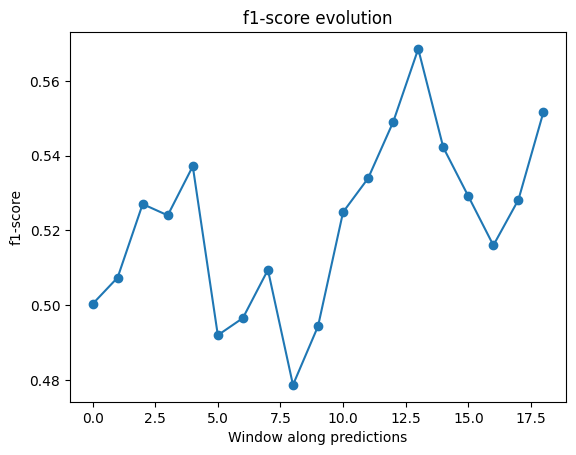

In [ ]:
assert(len(y_win) == len(y_win_true))
f1_scores = [f1_score(y_win_true[i], y_win[i], average='weighted') for i in range(len(y_win_true))]

plt.plot(range(len(f1_scores)), f1_scores, marker='o', linestyle='-')
plt.title('f1-score evolution')
plt.xlabel('Window along predictions')
plt.ylabel('f1-score')
plt.show()

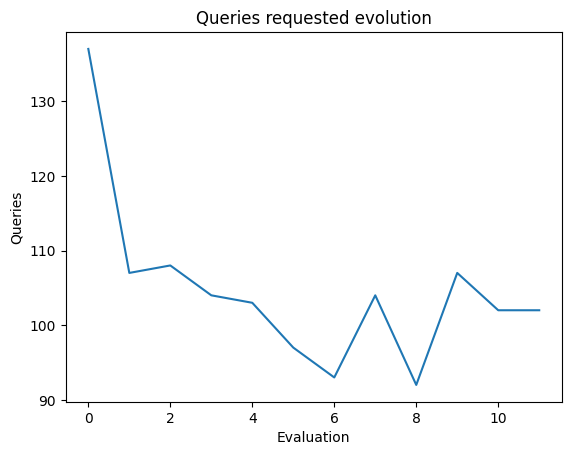

In [ ]:
plt.plot(range(len(queries_evolution_per_evaluation)), queries_evolution_per_evaluation)
plt.title('Queries requested evolution')
plt.xlabel('Evaluation')
plt.ylabel('Queries')
plt.show()

### General Results

In [ ]:
print("\nPredicting...")
y_preds = model1.predict(samples1_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        31
     Sitting and relaxing     0.0000    0.0000    0.0000        31
               Lying down     1.0000    0.9677    0.9836        31
                  Walking     0.9032    0.9333    0.9180        30
          Climbing stairs     0.8519    0.7667    0.8070        30
      Waist bends forward     0.8571    0.9600    0.9057        25
Frontal elevation of arms     0.0000    0.0000    0.0000        27
            Knees bending     0.8800    0.7586    0.8148        29
                  Cycling     0.7250    0.9355    0.8169        31
                  Jogging     0.7317    0.9677    0.8333        31
                  Running     0.9500    0.6333    0.7600        30
                     Jump     1.0000    0.8966    0.9455        29

                 accuracy          

In [ ]:
print(f"Percentage of queries asked: {len(list_queries)/len(samples1_active) * 100:.2f}%")

Percentage of queries asked: 51.77%


In [ ]:
# Plot evolution of scores reached on test
scores_x, scores_y = zip(*scores_evolution)
plt.plot(scores_x, scores_y, color='red')
plt.title('Evolution of Scores on Test Set')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
#plt.ylim([0.6,1])

plt.tight_layout()
plt.show()


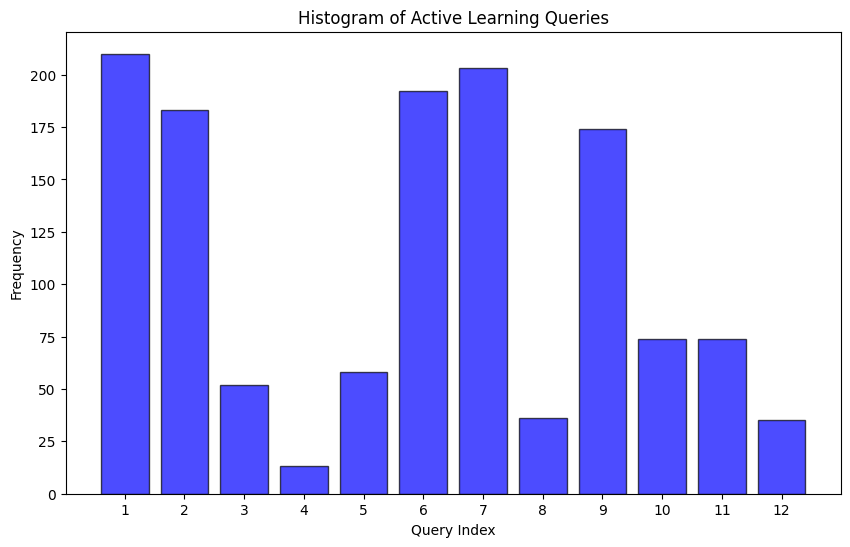

In [ ]:
query_counts = Counter(list_queries)
indices = list(query_counts.keys())
frequencies = list(query_counts.values())

indices = [index + 1 for index in indices]

plt.figure(figsize=(10, 6))
plt.bar(indices, frequencies, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('Query Index')
plt.ylabel('Frequency')
plt.title('Histogram of Active Learning Queries')

plt.xticks(indices)
plt.show()


(0.0, 1.0)

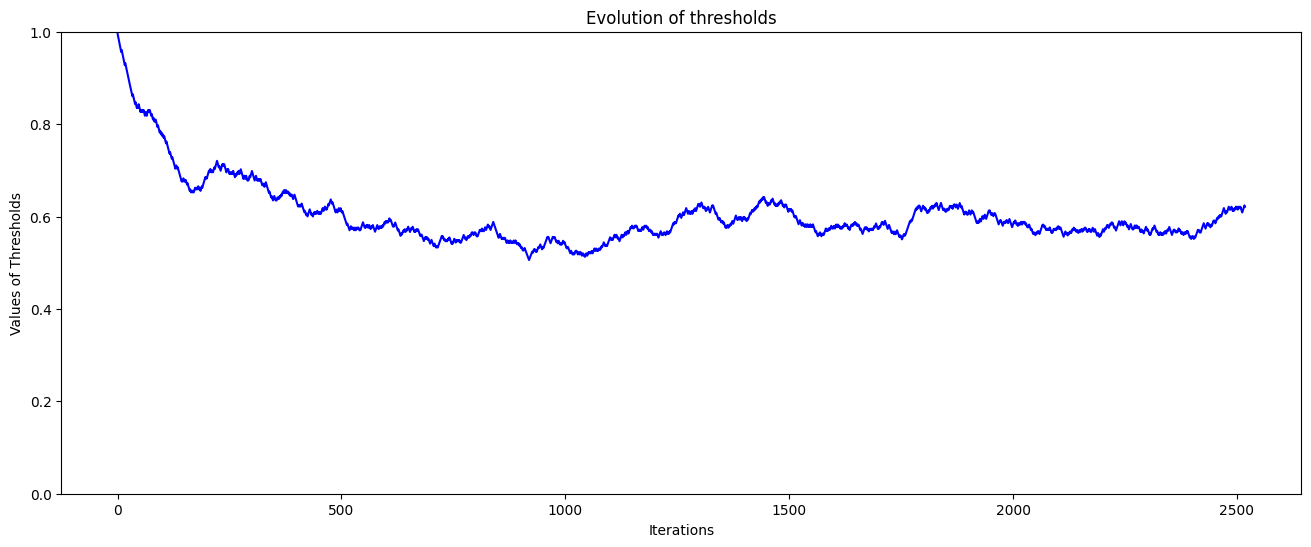

In [ ]:
# Plot evolution of thresholds

plt.figure(figsize=(16, 6))

plt.plot(thresholds_list, color='blue')
plt.title('Evolution of thresholds')
plt.xlabel('Iterations')
plt.ylabel('Values of Thresholds')
plt.ylim([0,1])

## Model 2

In [ ]:
# Active learning on Model2

print("\nSimulating Active Learning...\n")

threshold = 1
threshold_var = 0.005

number_of_queries = 0
number_of_queries_per_evaluation = 0
current_iteration = 0

batch_x, batch_y = [], []

# Lists to store evolution data

queries_evolution_per_evaluation = []

scores_evolution = []
fixed_test_scores = []
list_queries = []
thresholds_list = []
y_pred = []
y_pred_true = []

learning_rate = 0.000001
optimizer = Adam(learning_rate=learning_rate)

model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

for i in tqdm(range(len(samples2_active))):
    current_iteration += 1

    # Making predictions on real-time samples

    y_preds = model2.predict(samples2_active[i].reshape(1, 100, 9), verbose=0)
    prediction_certainty = np.max(y_preds[0])

    #print()
    #print(prediction_certainty)
    #print(np.argmax(labels1_active[i]), y_preds)

    # Evaluate on the fixed test set at specified intervals
    if current_iteration % evaluation_frequency == 0:
        queries_evolution_per_evaluation.append(number_of_queries_per_evaluation)
        number_of_queries_per_evaluation = 0

        y_preds_on_test = model2.predict(samples2_test, verbose=0)
        y_preds_on_test = np.argmax(y_preds_on_test, axis=1)
        y_targets_on_test = np.argmax(labels_test, axis=1)

        report = classification_report(y_targets_on_test, y_preds_on_test, target_names=classes, digits=4, zero_division=0, output_dict=True)
        f1 = report["weighted avg"]["f1-score"]
        print(f" - f1-score accurcy: {f1}\n")
        fixed_test_scores.append(f1)
        scores_evolution.append((current_iteration, f1))

    # Active learning: update model if prediction certainty is below threshold
    if prediction_certainty < threshold:
        number_of_queries_per_evaluation += 1

        number_of_queries += 1
        batch_x.append(samples2_active[i])
        batch_y.append(labels2_active[i])

        y_pred.append(np.argmax(y_preds))
        y_pred_true.append(np.argmax(labels2_active[i]))

        list_queries.append(np.argmax(labels2_active[i]))

        threshold -= threshold * threshold_var

        assert len(batch_x) == len(batch_y)
        if len(batch_x) >= batch_size_active:
            #numbers = [np.argmax(vector) for vector in batch_y]

            # Create a histogram
            #plt.hist(numbers, bins=range(len(batch_x[0]) + 1), edgecolor='black', align='left')
            #plt.xlabel('Number')
            #plt.ylabel('Frequency')
            #plt.title('Histogram of One-Hot Encoded Numbers')
            #plt.xlim([0,12])
            #plt.show()

            # Add samples from the training set to prevent catastrophic forgetting
            training_indices = np.random.choice(len(samples1_train), num_training_samples_per_batch, replace=False)
            training_samples = samples1_train[training_indices]
            training_labels = labels2_train[training_indices]

            batch_x.extend(training_samples)
            batch_y.extend(training_labels)

            # Shuffle the batch data before fitting the model
            batch_x, batch_y = shuffle(batch_x, batch_y, random_state=SEED)

            # Update model
            model2.fit(x=np.array(batch_x), y=np.array(batch_y), epochs=num_epochs, batch_size=batch_size, verbose=0)

            batch_x, batch_y = [], []


    else:
        threshold += threshold * threshold_var

    thresholds_list.append(threshold)



Simulating Active Learning...



  8%|▊         | 201/2519 [00:21<06:43,  5.74it/s]

 - f1-score accurcy: 0.5290842564032219



 16%|█▌        | 402/2519 [00:46<03:26, 10.26it/s]

 - f1-score accurcy: 0.5278603205429265



 24%|██▍       | 602/2519 [01:01<03:07, 10.24it/s]

 - f1-score accurcy: 0.5281739367501329



 32%|███▏      | 802/2519 [01:15<02:46, 10.30it/s]

 - f1-score accurcy: 0.5331600094832131



 40%|███▉      | 1002/2519 [01:33<01:35, 15.96it/s]

 - f1-score accurcy: 0.523021384387368



 48%|████▊     | 1202/2519 [01:48<01:35, 13.79it/s]

 - f1-score accurcy: 0.524948011041683



 56%|█████▌    | 1402/2519 [02:03<01:33, 11.97it/s]

 - f1-score accurcy: 0.5222634927294856



 64%|██████▎   | 1602/2519 [02:18<01:09, 13.28it/s]

 - f1-score accurcy: 0.522748887689718



 72%|███████▏  | 1803/2519 [02:34<00:46, 15.48it/s]

 - f1-score accurcy: 0.518404866389449



 79%|███████▉  | 2001/2519 [02:48<00:48, 10.72it/s]

 - f1-score accurcy: 0.5334512694838426



 87%|████████▋ | 2201/2519 [03:03<00:34,  9.21it/s]

 - f1-score accurcy: 0.5438742380333296



 95%|█████████▌| 2403/2519 [03:18<00:07, 14.88it/s]

 - f1-score accurcy: 0.5426591611140079



100%|██████████| 2519/2519 [03:27<00:00, 12.16it/s]


### Particular Results

In [ ]:
# Prepare lists to analyze

window_size = 256
overlap = 200

step = window_size - overlap

y_win = [y_pred[i:i+window_size] for i in range(0, len(y_pred) - window_size + 1, step)]
y_win_true = [y_pred_true[i:i+window_size] for i in range(0, len(y_pred_true) - window_size + 1, step)]


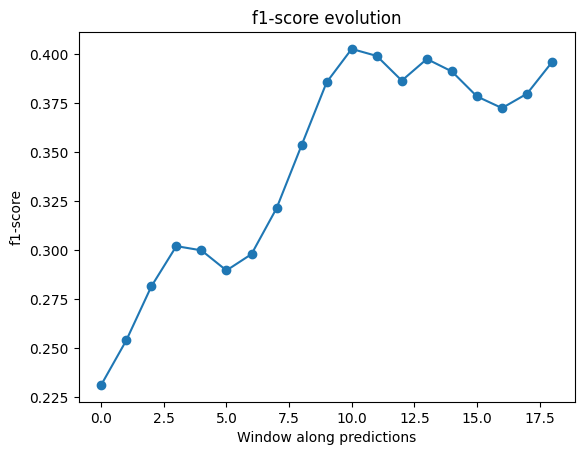

In [ ]:
# Evolution of f1-score on asked samples

assert(len(y_win) == len(y_win_true))
f1_scores = [f1_score(y_win_true[i], y_win[i], average='weighted') for i in range(len(y_win_true))]

plt.plot(range(len(f1_scores)), f1_scores, marker='o', linestyle='-')
plt.title('f1-score evolution')
plt.xlabel('Window along predictions')
plt.ylabel('f1-score')
plt.show()

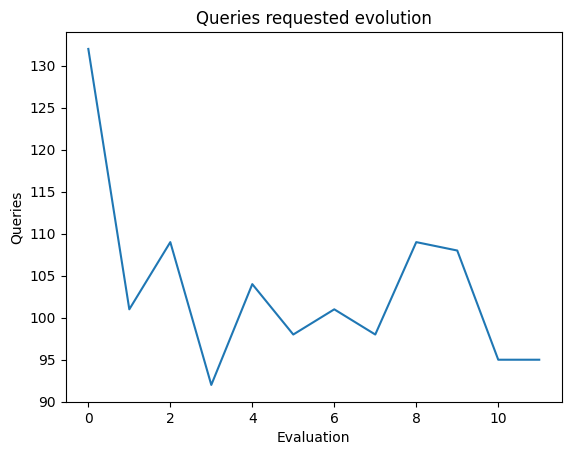

In [ ]:
plt.plot(range(len(queries_evolution_per_evaluation)), queries_evolution_per_evaluation)
plt.title('Queries requested evolution')
plt.xlabel('Evaluation')
plt.ylabel('Queries')
plt.show()

### General Results

In [ ]:
print("\nPredicting...")
y_preds = model2.predict(samples2_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        31
     Sitting and relaxing     0.7500    0.0968    0.1714        31
               Lying down     0.9677    0.9677    0.9677        31
                  Walking     0.9615    0.8333    0.8929        30
          Climbing stairs     0.3333    0.3667    0.3492        30
      Waist bends forward     0.1887    0.4000    0.2564        25
Frontal elevation of arms     0.6279    1.0000    0.7714        27
            Knees bending     0.0000    0.0000    0.0000        29
                  Cycling     0.4412    0.9677    0.6061        31
                  Jogging     1.0000    0.6774    0.8077        31
                  Running     0.7500    1.0000    0.8571        30
                     Jump     1.0000    1.0000    1.0000        29

                 accuracy          

In [ ]:
print(f"Percentage of queries asked: {len(list_queries)/len(samples2_active) * 100:.2f}%")

Percentage of queries asked: 51.53%


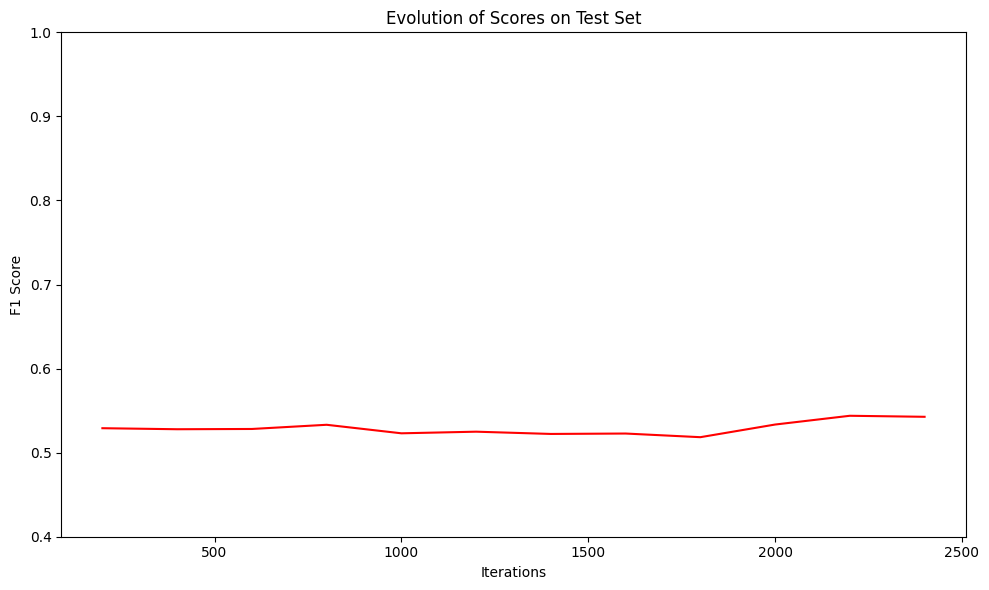

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot evolution of scores reached on test
scores_x, scores_y = zip(*scores_evolution)
plt.plot(scores_x, scores_y, color='red')
plt.title('Evolution of Scores on Test Set')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.ylim([0.4,1])

plt.tight_layout()
plt.show()


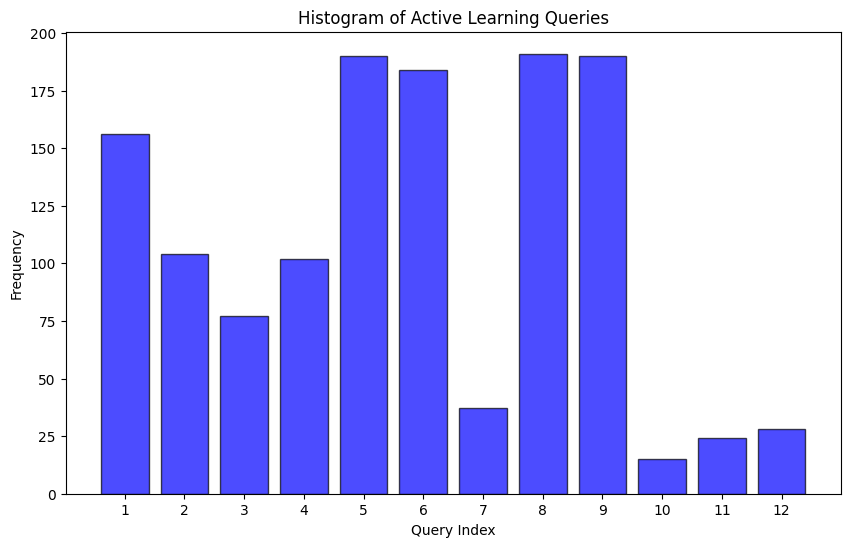

In [ ]:
query_counts = Counter(list_queries)
indices = list(query_counts.keys())
frequencies = list(query_counts.values())

indices = [index + 1 for index in indices]

plt.figure(figsize=(10, 6))
plt.bar(indices, frequencies, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('Query Index')
plt.ylabel('Frequency')
plt.title('Histogram of Active Learning Queries')

plt.xticks(indices)
plt.show()


(0.0, 1.0)

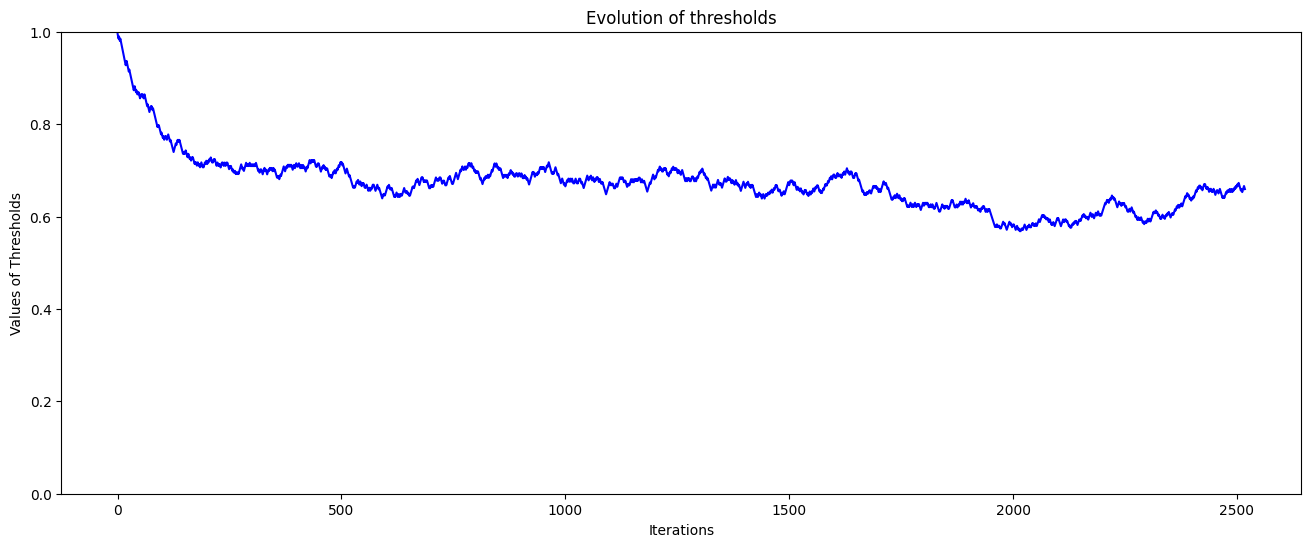

In [ ]:
# Plot evolution of thresholds

plt.figure(figsize=(16, 6))

plt.plot(thresholds_list, color='blue')
plt.title('Evolution of thresholds')
plt.xlabel('Iterations')
plt.ylabel('Values of Thresholds')
plt.ylim([0,1])

# EXP

In [ ]:
model = cnn_2D_acc_single_input()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

model.fit(x = samples1_active,
           y = labels1_active,
           batch_size=batch_size,
           epochs=30,
           validation_data=(samples1_test, labels_test))

Epoch 1/30
158/158 [==============================] - 2s 8ms/step - loss: 2.2648 - accuracy: 0.2342 - val_loss: 2.0244 - val_accuracy: 0.3127
Epoch 2/30
158/158 [==============================] - 1s 4ms/step - loss: 1.8607 - accuracy: 0.4077 - val_loss: 1.7159 - val_accuracy: 0.5268
Epoch 3/30
158/158 [==============================] - 1s 4ms/step - loss: 1.5930 - accuracy: 0.5383 - val_loss: 1.4674 - val_accuracy: 0.6394
Epoch 4/30
158/158 [==============================] - 1s 3ms/step - loss: 1.3872 - accuracy: 0.5820 - val_loss: 1.2931 - val_accuracy: 0.5915
Epoch 5/30
158/158 [==============================] - 1s 4ms/step - loss: 1.2265 - accuracy: 0.6189 - val_loss: 1.1820 - val_accuracy: 0.5972
Epoch 6/30
158/158 [==============================] - 1s 4ms/step - loss: 1.1048 - accuracy: 0.6554 - val_loss: 1.0599 - val_accuracy: 0.5831
Epoch 7/30
158/158 [==============================] - 1s 4ms/step - loss: 1.0031 - accuracy: 0.6733 - val_loss: 0.9803 - val_accuracy: 0.6225
Epoch 

In [ ]:
# Active learning on Model

print("\nSimulating Active Learning...\n")

model = cnn_2D_acc_single_input()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

current_iteration = 1
batch_x, batch_y = [], []

for i in tqdm(range(len(samples1_active))):
    current_iteration += 1

    batch_x.append(samples1_active[i])
    batch_y.append(labels1_active[i])

    # Evaluate on the fixed test set at specified intervals
    if current_iteration % 128 == 0:
        # Update model with current batch
        history = model.fit(x=np.array(batch_x), y=np.array(batch_y), epochs=num_epochs, batch_size=batch_size)

        batch_x, batch_y = [], []

        y_preds_on_test = model.predict(samples1_test, verbose=0)
        y_preds_on_test = np.argmax(y_preds_on_test, axis=1)
        y_targets_on_test = np.argmax(labels_test, axis=1)

        report = classification_report(y_targets_on_test, y_preds_on_test, target_names=classes, digits=4, zero_division=0, output_dict=True)
        f1 = report["weighted avg"]["f1-score"]
        print(f" - f1-score accuracy: {f1}\n")




Simulating Active Learning...



  0%|          | 0/2519 [00:00<?, ?it/s]

Epoch 1/50
8/8 [==============================] - 1s 17ms/step - loss: 2.5012 - accuracy: 0.0709
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 2.4318 - accuracy: 0.1339
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 2.4092 - accuracy: 0.1339
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 2.3937 - accuracy: 0.1339
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 2.3815 - accuracy: 0.1339
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 2.3610 - accuracy: 0.1339
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 2.3396 - accuracy: 0.1575
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 2.3248 - accuracy: 0.2047
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 2.2980 - accuracy: 0.2283
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 2.2858 - accuracy: 0.2283
Epoch 11/50
8/8 [=====================

  5%|▌         | 127/2519 [00:02<00:53, 44.37it/s]

 - f1-score accuracy: 0.32033603270529715

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 1.6276 - accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5793 - accuracy: 0.5391
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5685 - accuracy: 0.5469
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5441 - accuracy: 0.6094
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5232 - accuracy: 0.5859
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5096 - accuracy: 0.5469
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4923 - accuracy: 0.6172
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4739 - accuracy: 0.5781
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 1.4629 - accuracy: 0.6172
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4503 - accuracy: 0.6

 10%|█         | 255/2519 [00:04<00:41, 54.20it/s]

 - f1-score accuracy: 0.5595666574598088

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0650 - accuracy: 0.7031
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0563 - accuracy: 0.7109
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0455 - accuracy: 0.7188
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0343 - accuracy: 0.7109
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0080 - accuracy: 0.7109
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0041 - accuracy: 0.7500
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.9877 - accuracy: 0.7422
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0.9863 - accuracy: 0.7031
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.9752 - accuracy: 0.7422
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.9646 - accuracy: 0.72

 15%|█▌        | 383/2519 [00:07<00:39, 53.94it/s]

 - f1-score accuracy: 0.538769125026869

Epoch 1/50
8/8 [==============================] - 0s 5ms/step - loss: 0.9583 - accuracy: 0.6719
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8790 - accuracy: 0.7188
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8782 - accuracy: 0.6797
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8585 - accuracy: 0.6953
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.8526 - accuracy: 0.7578
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8523 - accuracy: 0.7188
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8297 - accuracy: 0.7031
Epoch 8/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8336 - accuracy: 0.7344
Epoch 9/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8164 - accuracy: 0.7578
Epoch 10/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8094 - accuracy: 0.734

 20%|██        | 511/2519 [00:12<00:55, 36.34it/s]

 - f1-score accuracy: 0.600008656433725

Epoch 1/50
8/8 [==============================] - 0s 3ms/step - loss: 0.8323 - accuracy: 0.6562
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.8007 - accuracy: 0.6406
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.8010 - accuracy: 0.6562
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7940 - accuracy: 0.7031
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7803 - accuracy: 0.6641
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7763 - accuracy: 0.6875
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7657 - accuracy: 0.6641
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.7668 - accuracy: 0.6797
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7613 - accuracy: 0.6797
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7567 - accuracy: 0.679

 25%|██▌       | 639/2519 [00:14<00:43, 42.97it/s]

 - f1-score accuracy: 0.7330298641302766

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.7448 - accuracy: 0.7031
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.7109
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.7188
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.6953
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.7344
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.7422
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.7188
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.6953
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.7266
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.71

 30%|███       | 767/2519 [00:16<00:36, 47.69it/s]

 - f1-score accuracy: 0.6338606236397827

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.7344
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5952 - accuracy: 0.7656
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5826 - accuracy: 0.7734
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5827 - accuracy: 0.7578
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5877 - accuracy: 0.7656
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5715 - accuracy: 0.7656
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5801 - accuracy: 0.7578
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5642 - accuracy: 0.7656
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5617 - accuracy: 0.7734
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5662 - accuracy: 0.78

 36%|███▌      | 895/2519 [00:19<00:34, 47.34it/s]

 - f1-score accuracy: 0.6672225639047727

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.7031
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.8047
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.8047
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.7891
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5944 - accuracy: 0.8281
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5980 - accuracy: 0.8047
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5904 - accuracy: 0.8438
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.8516
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5781 - accuracy: 0.8359
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5829 - accuracy: 0.80

 41%|████      | 1023/2519 [00:21<00:30, 48.48it/s]

 - f1-score accuracy: 0.8288417187269532

Epoch 1/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5591 - accuracy: 0.8125
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5412 - accuracy: 0.7734
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5389 - accuracy: 0.7500
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5086 - accuracy: 0.8047
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5185 - accuracy: 0.8203
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5035 - accuracy: 0.8594
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5118 - accuracy: 0.8281
Epoch 8/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5070 - accuracy: 0.8281
Epoch 9/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5004 - accuracy: 0.8359
Epoch 10/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4964 - accuracy: 0.85

 46%|████▌     | 1151/2519 [00:24<00:28, 47.87it/s]

 - f1-score accuracy: 0.8114280518836446

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.7500
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.7188
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.7578
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.7500
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.7500
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.7422
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6059 - accuracy: 0.7578
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.7266
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.7500
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.72

 51%|█████     | 1279/2519 [00:27<00:26, 47.67it/s]

 - f1-score accuracy: 0.7559775384525942

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5838 - accuracy: 0.8047
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5401 - accuracy: 0.8047
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5419 - accuracy: 0.8125
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5569 - accuracy: 0.7734
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5211 - accuracy: 0.7969
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5168 - accuracy: 0.8047
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5239 - accuracy: 0.7891
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5050 - accuracy: 0.8125
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5056 - accuracy: 0.8047
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5064 - accuracy: 0.80

 56%|█████▌    | 1407/2519 [00:30<00:23, 47.62it/s]

 - f1-score accuracy: 0.709575277013681

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.7891
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5793 - accuracy: 0.8359
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5672 - accuracy: 0.7891
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5610 - accuracy: 0.8281
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5679 - accuracy: 0.7891
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5883 - accuracy: 0.8125
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5454 - accuracy: 0.8203
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5470 - accuracy: 0.8047
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5322 - accuracy: 0.8281
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5244 - accuracy: 0.812

 61%|██████    | 1535/2519 [00:32<00:20, 47.58it/s]

 - f1-score accuracy: 0.797064183723428

Epoch 1/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6202 - accuracy: 0.7266
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.7578
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5310 - accuracy: 0.8125
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5223 - accuracy: 0.8203
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5153 - accuracy: 0.8281
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5108 - accuracy: 0.8125
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5066 - accuracy: 0.8203
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5000 - accuracy: 0.8125
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4906 - accuracy: 0.8203
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4986 - accuracy: 0.820

 66%|██████▌   | 1663/2519 [00:35<00:18, 47.26it/s]

 - f1-score accuracy: 0.8017881862435583

Epoch 1/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6319 - accuracy: 0.7812
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6052 - accuracy: 0.8047
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5909 - accuracy: 0.7656
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5804 - accuracy: 0.7891
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5775 - accuracy: 0.7969
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5767 - accuracy: 0.7812
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5517 - accuracy: 0.8125
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5685 - accuracy: 0.7734
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5446 - accuracy: 0.7969
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5449 - accuracy: 0.84

 71%|███████   | 1791/2519 [00:38<00:15, 47.48it/s]

 - f1-score accuracy: 0.8218519428606216

Epoch 1/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5528 - accuracy: 0.8125
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5467 - accuracy: 0.8125
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5269 - accuracy: 0.7891
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5363 - accuracy: 0.7891
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4901 - accuracy: 0.8359
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5102 - accuracy: 0.8047
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4957 - accuracy: 0.7969
Epoch 8/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4840 - accuracy: 0.8359
Epoch 9/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5029 - accuracy: 0.8125
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4831 - accuracy: 0.83

 76%|███████▌  | 1919/2519 [00:40<00:12, 47.35it/s]

 - f1-score accuracy: 0.8155041371575833

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6060 - accuracy: 0.7891
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.7891
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5926 - accuracy: 0.8047
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.7812
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5858 - accuracy: 0.8047
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5928 - accuracy: 0.7656
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5811 - accuracy: 0.8516
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5805 - accuracy: 0.8359
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5906 - accuracy: 0.7734
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5827 - accuracy: 0.81

 81%|████████▏ | 2047/2519 [00:43<00:09, 47.43it/s]

 - f1-score accuracy: 0.8218722970941621

Epoch 1/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7591 - accuracy: 0.7578
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.7422
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.7734
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.7812
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.7891
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.7656
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.7734
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.7969
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.7969
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.75

 86%|████████▋ | 2175/2519 [00:45<00:06, 50.86it/s]

 - f1-score accuracy: 0.8243585075043564

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5369 - accuracy: 0.8438
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4880 - accuracy: 0.8359
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4693 - accuracy: 0.8047
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4712 - accuracy: 0.8516
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4652 - accuracy: 0.8438
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4753 - accuracy: 0.8281
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4767 - accuracy: 0.8594
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4641 - accuracy: 0.8594
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4416 - accuracy: 0.8516
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4398 - accuracy: 0.83

 91%|█████████▏| 2303/2519 [00:47<00:04, 53.05it/s]

 - f1-score accuracy: 0.7396547473508787

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5044 - accuracy: 0.7812
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4562 - accuracy: 0.8047
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.8203
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4502 - accuracy: 0.8203
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4370 - accuracy: 0.8281
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4304 - accuracy: 0.8594
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4373 - accuracy: 0.8203
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4279 - accuracy: 0.8438
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4184 - accuracy: 0.8828
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4111 - accuracy: 0.86